<a href="https://colab.research.google.com/github/gabrielmelo00/Machine-Learning-Projects/blob/main/Audio_Source_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Source Separation Practical Work

Telecom Paris - TSIA 206

* Gabriel Melo
* Gabriela Barbosa Guedes Pereira

In [ ]:
!pip install mdct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import hamming
from scipy.spatial.distance import cdist

import IPython.display as ipd
from mdct.fast import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.Audio(data.T, rate=rate)

### Exercise 1

We could hear a bass and a guitar playing in the left and the right and a piano that perceived from both directions. 

T = 220501, M = 2


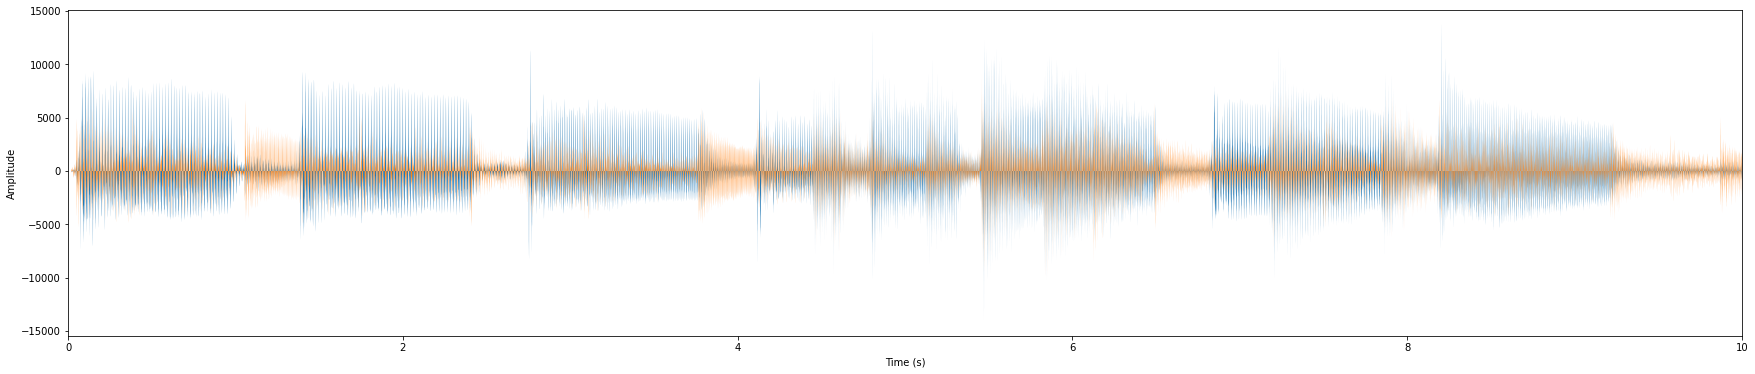

In [ ]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

In [ ]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

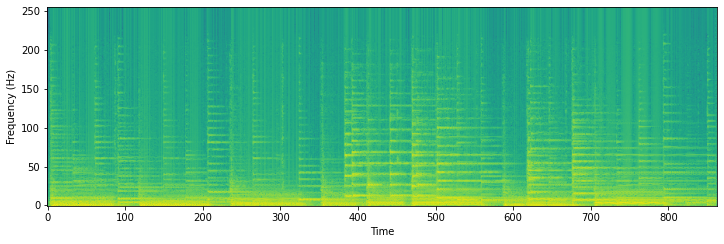

In [ ]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

### Exercise 2

We can notice from the plot below that it is impossible to distinguish the directions of the sources only by observing the temporal dispersion diagram.

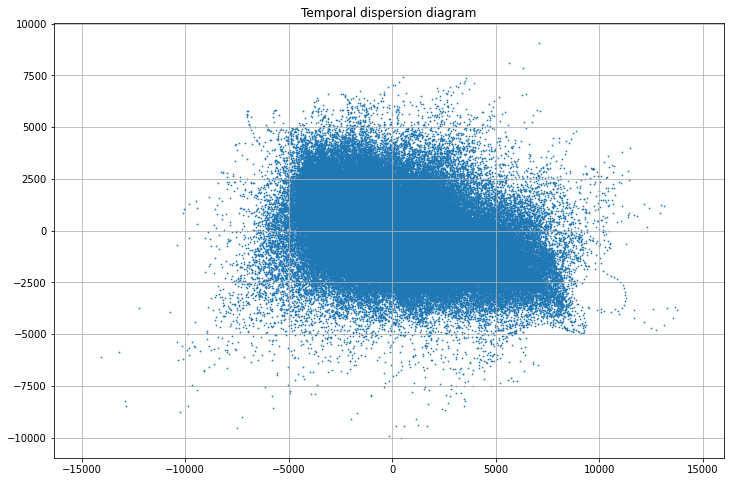

In [ ]:
plt.axis('equal')
plt.scatter(x[:, 0], x[:, 1], s=0.5)
plt.axis("equal")
plt.grid('on')
plt.title("Temporal dispersion diagram")
plt.show()

### Exercise 3

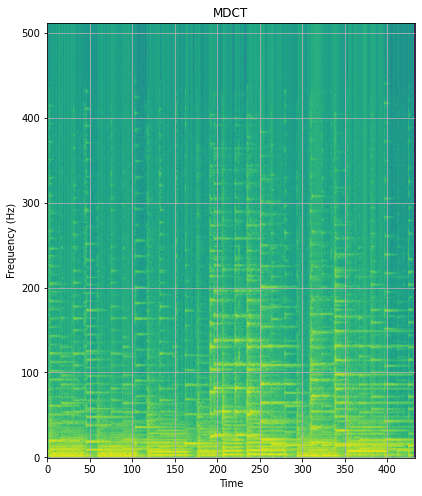

In [ ]:
X = mdct(x, window=hamming)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.grid('on')
plt.title("MDCT")
plt.show()

### Exercide 4

From the plot below, we are able now to better distinguish three different directions of the sources. That is due to the application of the MDCT transform, because the time-frequency representations of audio signals are usually more sparse than in time domain.


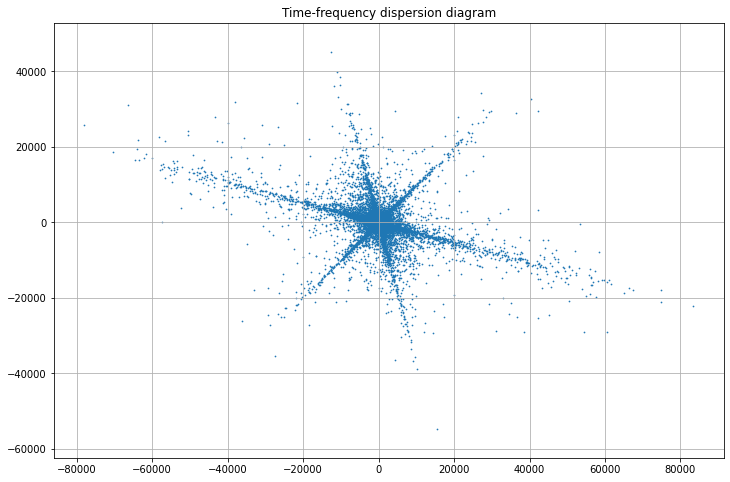

In [ ]:
plt.axis('equal')
plt.scatter(Z.real, Z.imag, s=0.5)
plt.axis("equal")
plt.grid('on')
plt.title("Time-frequency dispersion diagram")
plt.show()

### Exercise 5

By looking at the histogram below, we can estimate the angles in −1.3, −0.25  and 0.77

In [ ]:
angles = np.arctan(np.real(Z)/np.imag(Z))

for i in range(Z.shape[0]):
  for j in range(Z.shape[1]):

    if np.isnan(angles[i][j]):
      
      if (np.imag(Z)[i][j]>0):
        angles[i][j] = np.pi/2

      if (np.imag(Z)[i][j]<0):
        angles[i][j] = -np.pi/2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


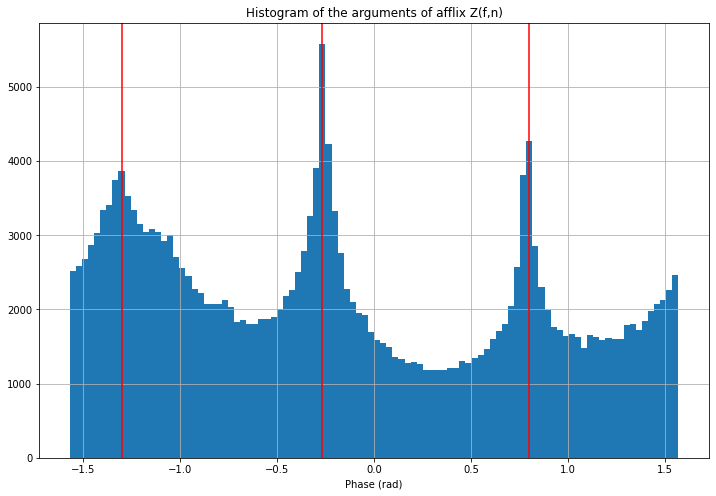

In [ ]:
plt.hist(angles[~np.isnan(angles)], bins=100)
plt.axvline(-1.3, color='red')
plt.axvline(-0.27, color='red')
plt.axvline(0.80, color='red')
plt.grid('on')
plt.title("Histogram of the arguments of afflix Z(f,n)")
plt.xlabel("Phase (rad)")
plt.show()

### Exercise 6

In [ ]:
thetas = np.array([-1.3, -0.27, 0.80])

In [ ]:
B = np.zeros((Z.shape[0], Z.shape[1], 3))

for i in range(Z.shape[0]):
  for j in range(Z.shape[1]):
      distances = np.sin(np.abs(thetas - angles[i][j]))
      B[i, j, np.argmin(distances)] = 1

### Exercise 7

In [ ]:
Y = np.zeros((Z.shape[0], Z.shape[1], 2, 3))
Y_reconstruct = np.zeros((221184, 2, 3))

for i in range(3):
  for j in range(2):
    Y[:, :, j, i] = B[:, :, i] * X[:, :, j]
  Y_reconstruct[:, :, i] = (imdct(Y[:, :, :, i]))

/usr/local/lib/python3.7/dist-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/usr/local/lib/python3.7/dist-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


In [ ]:
# source 1
play_sound(Y_reconstruct[:, :, 0], rate)

In [ ]:
# source 2
play_sound(Y_reconstruct[:, :, 1], rate)

In [ ]:
# source 3
play_sound(Y_reconstruct[:, :, 2], rate)

### Exercise 8

We could satisfactoryly isolate the signals, but there are still some defects on it. We can understand some noise from the other instruments in the background. 

### Exercise 9

In [ ]:
S = np.zeros((Y.shape[0], Y.shape[1], 3))

for k in range(3):
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      S[i, j, k] = Y[i, j, 0, k]*np.cos(thetas[k]) + Y[i, j, 1, k]*np.sin(thetas[k])

S = S.reshape((512//2, -1,3))

In [ ]:
sig_1 = imdct(S[:,:,0], window=hamming, framelength=512)
play_sound(sig_1, rate)

/usr/local/lib/python3.7/dist-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/usr/local/lib/python3.7/dist-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


In [ ]:
sig_2 = imdct(S[:,:,1], window=hamming, framelength=512)
play_sound(sig_2, rate)

/usr/local/lib/python3.7/dist-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/usr/local/lib/python3.7/dist-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


In [ ]:
sig_3 = imdct(S[:,:,2], window=hamming, framelength=512)
play_sound(sig_3, rate)

/usr/local/lib/python3.7/dist-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/usr/local/lib/python3.7/dist-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


### Exercise 10

In [ ]:
A = np.zeros((3, 2))
for i in range(3):
  A[i, 0] = np.cos(thetas[i])
  A[i, 1] = np.sin(thetas[i])

In [ ]:
s = np.array([sig_1, sig_2, sig_3]).T

In [ ]:
x_reconstructed = s.dot(A)
play_sound(x_reconstructed, rate)